In [127]:
import pybamm
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from joblib import Parallel, delayed
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

from IPython.display import Audio
url = "https://proxy.notificationsounds.com/wake-up-tones/you-have-new-message-484/download/file-a1_ascendent-64kbps.mp3"
notify=Audio(url = url, autoplay = True)

########## pickle commands for dumping and retrieving data #######
# filename = 'dogs'
# outfile = open(filename,'wb')
# pickle.dump(dogs_dict,outfile)
# outfile.close()
# infile = open(filename,'rb')
# data = pickle.load(infile)
# infile.close()

########### parallel computations command ####################
# data = Parallel(n_jobs=-1)(delayed(my_function)(i) for i in my_iterable)

In [128]:
model = pybamm.lithium_sulfur.ZhangEtAl2015()
params = model.default_parameter_values

R = model.param.R.value
F = model.param.F.value
T = params[model.param.T_ref.name]
N = model.param.N.value

# model-specific known parameters
'''
For the stochiometric sij paramters, i indicates species of Sulfur and j reaction number.
For example, S6 in reaction 3 has s63.
The one exception is for S8(s), which has S instead of an integer. 
'''
sLi1 = params[model.param.sLi1.name]
sS2 = params[model.param.sS2.name]
s82 = params[model.param.s82.name]
s83 = params[model.param.s83.name]
s63 = params[model.param.s63.name]
s64 = params[model.param.s64.name]
s44 = params[model.param.s44.name]
s45 = params[model.param.s45.name]
s25 = params[model.param.s25.name]
s26 = params[model.param.s26.name]
s16 = params[model.param.s16.name]

E01 = params[model.param.E01.name]
E02 = params[model.param.E02.name]
E03 = params[model.param.E03.name]
E04 = params[model.param.E04.name]
E05 = params[model.param.E05.name]
E06 = params[model.param.E06.name]

n1 = -params[model.param.n1.name]*-1
n2 = -params[model.param.n2.name]*-1
n3 = -params[model.param.n3.name]*-1
n4 = -params[model.param.n4.name]*-1
n5 = -params[model.param.n5.name]*-1
n6 = -params[model.param.n6.name]*-1

i02 = params[model.param.i02.name]
i03 = params[model.param.i03.name]
i04 = params[model.param.i04.name]
i05 = params[model.param.i05.name]
i06 = params[model.param.i06.name]

A = params[model.param.Area.name]
l = params[model.param.l.name]
V_Li2S = params[model.param.V_Li2S.name]
nu0_Li2S = params[model.param.nu0_Li2S.name]
Li0 = params[model.param.Li0.name]
k_p = params[model.param.k_p.name]
K_sp = params[model.param.K_sp.name]
av0 = params[model.param.av0.name]
ep0 = params[model.param.ep0.name]
sigma0 = params[model.param.sigma0.name]
xi = params[model.param.xi.name]
b = params[model.param.b.name]
eta1 = params[model.param.eta1.name]

In [129]:
S8s = 6.7e2
S8 = 1e2
S6 = 8.2
S4 = 5.6e-3
S2 = 8e-6
S = 1.4e-8
Li = 2*(S8 + S6 + S4 + S2 + S)  + Li0

# Reduction Potential as given in Equation (14) of [1]
E1 = E01 - (R*T/(n1*F))*sLi1*np.log(Li/1000) 

# Reduction Potential as given in Equation (14) of [1]
E2 = E02 - (R*T/(n2*F))*( sS2*np.log(S8s/1000) + s82*np.log(S8/1000) )

# Reduction Potential as given in Equation (14) of [1]
E3 = E03 - (R*T/(n3*F))*( s83*np.log(S8/1000) + s63*np.log(S6/1000) )

# Reduction Potential as given in Equation (14) of [1]
E4 = E04 - (R*T/(n4*F))*( s64*np.log(S6/1000) + s44*np.log(S4/1000) )

# Reduction Potential as given in Equation (14) of [1]
E5 = E05 - (R*T/(n5*F))*( s45*np.log(S4/1000) + s25*np.log(S2/1000) )

# Reduction Potential as given in Equation (14) of [1]
E6 = E06 - (R*T/(n6*F))*( s26*np.log(S2/1000) + s16*np.log(S/1000) )


In [130]:
I = 3.45
Rs = l/(A*(ep0**1.5)*(sigma0-b*(Li-Li0)))
V = 1.5
V - E2 + E1 + I*Rs

-0.4195540599797178

In [131]:
def initial(eta2):
    I = .36

    # Overpotential implied by equation (8) in [1]
    eta3 = E2 + eta2 - E3

    # Overpotential implied by equation (8) in [1]
    eta4 = E2 + eta2 - E4

    # Overpotential implied by equation (8) in [1]
    eta5 = E2 + eta2 - E5

    # Overpotential implied by equation (8) in [1]
    eta6 = E2 + eta2 - E6

    # Reaction current functions defined in equation (12) in [1]
    i2 = 2*i02*np.sinh(n2*F*eta2/(2*R*T))

    # Reaction current functions defined in equation (12) in [1]
    i3 = 2*i03*np.sinh(n3*F*eta3/(2*R*T))

    # Reaction current functions defined in equation (12) in [1]
    i4 = 2*i04*np.sinh(n4*F*eta4/(2*R*T))

    # Reaction current functions defined in equation (12) in [1]
    i5 = 2*i05*np.sinh(n5*F*eta5/(2*R*T))

    # Reaction current functions defined in equation (12) in [1]
    i6 = 2*i06*np.sinh(n6*F*eta6/(2*R*T))

    return av0*(i2 + i3 + i4 + i5 + i6) - (I/(A*l))

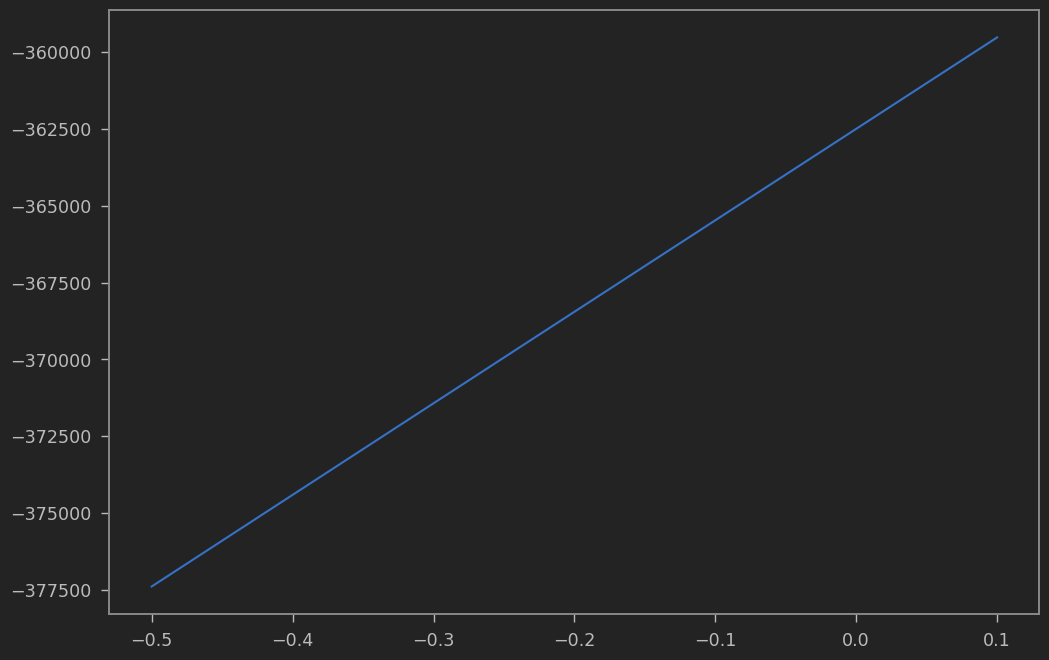

In [132]:
delta = 1
eta2 = np.linspace(-.5,.1,100)
I_out = initial(eta2/1000)

plt.plot(eta2, I_out)

In [124]:
from scipy import optimize
sol = optimize.root_scalar(initial, bracket=[-.2,.5], method='brentq', rtol=1e-15)

In [125]:
eta2 = sol.root
print(E2+eta2+E1+(-.36)*Rs)

2.374020313949443


In [126]:
eta2

0.012396349308440097

In [76]:
from scipy import optimize
sol = optimize.root(initial, .2, tol=1e-6)

In [67]:
sol

    fjac: array([[-1.]])
     fun: array([5.66069502e-09])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.21989069e-06])
       r: array([-29032958.34244969])
  status: 1
 success: True
       x: array([0.01239635])